In [ ]:
#73c9a156b91f3e0c01c3d5f332d23bfc66f4cdbf

In [1]:
import wandb
wandb.init(project="DoubleDQN", entity = "rl_proj")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roysgc (rl_proj). Use `wandb login --relogin` to force relogin


In [2]:
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import namedtuple, deque
import time
from ale_py import ALEInterface
import imageio
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

ale = ALEInterface()

np.random.seed(42)
tf.random.set_seed(42)



class Config:
    EPSILON_START = 1.0
    EPSILON_END = 0.01
    EPSILON_DECAY_RATE = 0.99  
    EPISODES = 1500 
    TARGET_UPDATE = 100
    BATCH_SIZE = 128
    GAMMA = 0.999

config = Config()
best_reward = 0

env = gym.make("Assault-v4") 
n_actions = env.action_space.n

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(keras.Model):

    def __init__(self, n_actions):
        super(DQN, self).__init__()

        self.layer1 = layers.Conv2D(16, 5, strides=2, activation="relu")
        self.bn1 = layers.BatchNormalization()
        self.layer2 = layers.Conv2D(16, 5, strides=2, activation="relu")
        self.bn2 = layers.BatchNormalization()
        self.layer3 = layers.Conv2D(32, 5, strides=2, activation="relu")
        self.bn3 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.layer4 = layers.Dense(512, activation="relu")
        self.action = layers.Dense(n_actions, activation="linear")

    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.bn1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.layer4(x)
        return self.action(x)

# Creación del modelo y la memoria
model = DQN(n_actions)
model_target = DQN(n_actions)
memory = ReplayMemory(10000)

# Preparación del optimizador y la función de pérdida
optimizer = keras.optimizers.Adam(learning_rate=2.5e-4, clipnorm=1.0)
loss_function = keras.losses.Huber()

def take_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        q_values = model.predict(state[np.newaxis, ...])
        return np.argmax(q_values[0])

def optimize_modelDDQN():
    if memory.__len__() < config.BATCH_SIZE:
        return
    transitions = memory.sample(config.BATCH_SIZE)
    batch = memory.transition(*zip(*transitions))

    state_batch = np.array(batch.state)
    action_batch = np.array(batch.action)
    next_state_batch = np.array(batch.next_state)
    rewad_batch = np.array(batch.reward)
    done_batch = np.array(batch.done, dtype=np.int8)

    # Calculate Q-values for the next state using the online model
    q_values_next_state_online = model(next_state_batch)

    # Use the online model to select actions for the next state
    next_actions_online = np.argmax(q_values_next_state_online, axis=-1)

    # Use the target model to calculate Q-values for the next state and selected actions
    q_values_next_state_target = model_target(next_state_batch)
    q_values_next_state_target_selected = tf.reduce_sum(
        tf.one_hot(next_actions_online, n_actions) * q_values_next_state_target,
        axis=-1
    )

    target = rewad_batch + config.GAMMA * q_values_next_state_target_selected * (1 - done_batch)

    action_mask = tf.one_hot(action_batch, n_actions)

    with tf.GradientTape() as tape:
        q_values = model(state_batch)
        q_action = tf.reduce_sum(tf.multiply(q_values, action_mask), axis=-1)
        loss = loss_function(target, q_action)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    wandb.log({"loss": loss.numpy()})
    return loss

    #model.save_weights('/Users/roy/Desktop/UNI')

def display_frames(frames):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = plt.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(anim)

def save_gif(frames, episode_number):
    gif_path = f"episode_{episode_number}.gif"
    imageio.mimsave(gif_path, frames, format='GIF', fps=30)

    # Log the GIF to wandb
    wandb.log({"episode_gif": wandb.Video(gif_path, fps=30)})

    return gif_path



episode_rewards = []
losses = []

best_reward = float("-inf")
best_episode = 0
best_frames = []

# Entrenamiento del agente
epsilon = config.EPSILON_START
for episode in range(config.EPISODES):
    #reset_result = env.reset()
    #state = reset_result[0] / 255.0
    #info = reset_result[1]

    state = env.reset() / 255.0
    done = False
    episode_reward = 0
    steps = 0
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}

    frames = []
    current_frames = []  # Almacena los frames del episodio actual
    episode_reward = 0

    while not done and  info.get("ale.lives") > 0:
        action = take_action(state, epsilon)
        
        step_result = env.step(action)
        
        next_state, reward, done, info = step_result

        next_state = next_state / 255.0

        memory.push(state, action, next_state, reward, done)
        #loss = optimize_modelDDQN()
        optimize_modelDDQN()

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("step: ", steps, "action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))

        steps += 1
        
        
        
    print(f"\nEpisodio: {episode+1}, Recompensa: {episode_reward}, Epsilon: {epsilon}")
    
    if episode_reward > best_reward:
        best_reward = episode_reward

        #CAMBIAR PATH a la carpeta doubleDQN
        model.save("./best_DDQN_model", save_format="tf")
        #CAMBIAR PATH a la carpeta doubleDQN
        model_target.save("./best_DDQN_model_target", save_format="tf")
        print("New best model saved")

        gif_path = f"./episode_{episode+1}_reward_{episode_reward}.gif"

        imageio.mimsave(gif_path, frames, fps=30)
    
    episode_rewards.append(episode_reward)
    
    epsilon = max((epsilon * config.EPSILON_DECAY_RATE), config.EPSILON_END)
    
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon":epsilon})
    
   
    
    if (episode + 1) % config.TARGET_UPDATE == 0:
        model_target.set_weights(model.get_weights())


env.close()


step:  22 action:  6  reward:  21.0
Lives:  4
step:  67 action:  2  reward:  21.0
Lives:  4
step:  146 action:  1  reward:  21.0
Lives:  4
step:  265 action:  0  reward:  21.0
Lives:  3
step:  305 action:  0  reward:  21.0
Lives:  3
step:  333 action:  5  reward:  21.0
Lives:  3
step:  359 action:  3  reward:  21.0
Lives:  3
step:  400 action:  5  reward:  21.0
Lives:  2
step:  471 action:  3  reward:  21.0
Lives:  2
step:  515 action:  0  reward:  21.0
Lives:  1
step:  623 action:  4  reward:  21.0
Lives:  1
step:  656 action:  5  reward:  21.0
Lives:  1
step:  708 action:  5  reward:  21.0
Lives:  1
step:  739 action:  0  reward:  21.0
Lives:  1

Episodio: 1, Recompensa: 294.0, Epsilon: 1.0


INFO:tensorflow:Assets written to: /Users/roy/Desktop/EXAMPML/RL_Project/Assault/doubleDQN/best_DDQN_model/assets


INFO:tensorflow:Assets written to: /Users/roy/Desktop/EXAMPML/RL_Project/Assault/doubleDQN/best_DDQN_model/assets


INFO:tensorflow:Assets written to: /Users/roy/Desktop/EXAMPML/RL_Project/Assault/doubleDQN/best_DDQN_model_target/assets


INFO:tensorflow:Assets written to: /Users/roy/Desktop/EXAMPML/RL_Project/Assault/doubleDQN/best_DDQN_model_target/assets


New best model saved with reward: 294.0
step:  13 action:  3  reward:  21.0
Lives:  4


KeyboardInterrupt: 

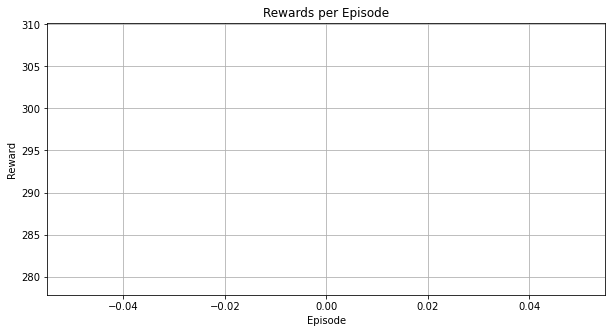

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)

#CAMBIAR PATH a carpeta doubleDQN
plot_path = f"./rewards_plot.png"
plt.savefig(plot_path)

# Log the plot to WandB
wandb.log({"Training process of DQN": wandb.Image(plot_path)})

In [5]:
#TEST THE SAVED MODEL
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Carga los modelos
#CAMBIAR PATH A DONDE ESTA EL MODELO
DQN_model = keras.models.load_model("./best_DDQN_model")

#CAMBIAR PATH A DONDE ESTA EL MODELO
DQN_model_target = keras.models.load_model("./best_DDQN_model_target")

# Crea el entorno
env = gym.make("Assault-v4")
n_actions = env.action_space.n

def take_action(state):
    q_values = model.predict(state[np.newaxis, ...])
    return np.argmax(q_values[0])


rewards_per_episode = []
best_reward = 0

for episode in range(500):
    state= env.reset()
    state = state / 255.0  
    done = False
    episode_reward = 0
    frames = []
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}

    while not done:
        action = take_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = next_state / 255.0  

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))
        
        #steps += 1

    rewards_per_episode.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

    if episode_reward > best_reward:
        best_reward = episode_reward 
        
        gif_path = f"./test_episode_{episode+1}_reward_{episode_reward}.gif"
        imageio.mimsave(gif_path, frames, fps=30)

    # Log episode metrics and GIF to wandb
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon, "episode_gif": wandb.Video(gif_path, fps=4, format="gif")})


env.close()

# Grafica las recompensas por episodio
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

1/1 [==============================] - 0s 21ms/step
step:  27 action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 22ms/step
step:  27 action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 21ms/step
step:  27 action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 20ms/step
step:  27 action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 23ms/step
step:  27 action:  0  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 21ms/step
step:  27 action:  0  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 22ms/step
step:  27 action:  3  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: 